In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from portfolio_env_framework import *
from portfolio_env_with_tcost import *
import random
import torch
import numpy.typing as npt

In [2]:
class BasicDataManager(AbstractPortfolioEnvWithTCost):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.universe_size+1, 100+2), dtype=np.float32)

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('100_random_sample_tickers.csv')
        self.tickers = df.TICKER.unique()
        
        # create stock array
        pivot_price_df = df.pivot(index='date', columns='TICKER', values='PRC')
        stock_array = pivot_price_df.values.astype(float)
        
        # adjust for stock splits
        pivot_facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR')
        facpr_array = pivot_facpr_df.values.astype(float)
        self.stock_array = stock_array * (1+facpr_array).cumprod(axis=0)
        self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
        
        # print(normal_ret)
    
        normal_ret = pivot_price_df.pct_change().iloc[1:, :]

        self.times = df.date.unique()[100:]

        exp_ret = np.exp(self.ret)
        self.idx_df = pd.DataFrame(exp_ret, index = df.date.unique()[1:])
    
        
        # read index data and compute volatilities
        daily_return = normal_ret.mean(axis = 1)
        
        
        vol_20 = daily_return.rolling(20).std()
        vol_60 = daily_return.rolling(60).std()
        self.vol_20 = vol_20[self.times].values
        self.vol_60 = vol_60[self.times].values
        
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix = vix_df.loc[self.times].vix.values
        
        
        self.num_time_periods = len(self.times)-100-1
        self.universe_size = len(self.tickers)

        #get news sentiment data
        means_df = pd.read_csv('./news_sentiment_data_5.csv')
        means_df['Date'] = pd.to_datetime(means_df['Date'], errors='coerce')

        #filter date range
        means_df = means_df[(means_df.Date.dt.year >= 2010) & (means_df.Date.dt.year < 2015)]
        means_df = means_df.loc[means_df['Ticker'].isin(self.tickers)]

        #pivot to create an array that's easier to work with
        news_sentiment_array = means_df.pivot(index="Date", columns="Ticker", values="sentiment_embedding")
        
        #reindex the dataframe so that missing times are filled properly
        news_sentiment_array = news_sentiment_array.reindex(self.times).fillna(0)
        no_sentiment_tickers = list(set(self.tickers) - set(news_sentiment_array.columns.values))

        news_sentiment_array[[no_sentiment_tickers]] = 0
        self.news_sentiment_array = news_sentiment_array
       

        return len(self.times)-100 - 1, len(self.tickers)
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        
        s = np.zeros((self.universe_size+1, 100+2))
        s[:, 0] = w
        s[:-1, 1:-1] = self.ret[t:t+100, :].T
        s[:-1, -1] = self.news_sentiment_array.loc[self.times[t+100-1]].values
        s[-1, 1] = self.vol_20[t]
        s[-1, 2] = self.vol_20[t] / self.vol_60[t]
        s[-1, 3] = self.vix[t]
        
        return s

    def get_prices(self, t) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        return np.append(self.stock_array[t+100, :].flatten(), 1.0)

In [3]:
class DifferentialSharpeRatioReward(AbstractRewardManager):
    def __init__(self, eta: float = 1/252):
        self.eta = eta
        self.initialize_reward()

    def initialize_reward(self):
        self.A, self.B = 0.0, 0.0

    def compute_reward(self, old_port_val: float, new_port_val: float) -> float:
        R = np.log(new_port_val / old_port_val)
        dA = R - self.A
        dB = R ** 2 - self.B
        if self.B - self.A ** 2 == 0:
            D = 0
        else:
            D = (self.B * dA - 0.5 * self.A * dB) / (self.B - self.A ** 2) ** (3 / 2)
        self.A += self.eta * dA
        self.B += self.eta * dB
        return D

In [22]:
# Parallel environments
vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
    'dm': BasicDataManager(),
    'rm': DifferentialSharpeRatioReward(),
    'cp': 0,
    'cs': 0
})

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(43)
torch.manual_seed(42)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=100_000)
model.save("tcost_portfolio_rl_model_framework_full_news")

/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_44699/1947511858.py:18: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_44699/1947511858.py:18: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_44699/1947511858.py:18: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_44699/1947511858.py:18: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_44699/194

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.06e+03 |
|    ep_rew_mean     | -23.4    |
| time/              |          |
|    fps             | 4274     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -23.1       |
| time/                   |             |
|    fps                  | 1441        |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.059909888 |
|    clip_fraction        | 0.386       |
|    clip_range           | 0.2         |
|    entropy_loss         | -143        |
|    explained_variance   | 0.00138     |
|    learning

In [25]:
env = PortfolioEnvWithTCost(dm=BasicDataManager(), rm=DifferentialSharpeRatioReward(), cp=0, cs=0)
obs, _ = env.reset()

port_val = [1.0]
eq_pf_val = [1.0]
actions = []
ys = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    port_val.append(info['port_val'])
    eq_pf_val.append(eq_pf_val[-1] * (env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t]].mean(axis = 1).values[0]))
    if terminated:
        break

/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_44699/1947511858.py:18: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_44699/1947511858.py:18: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))


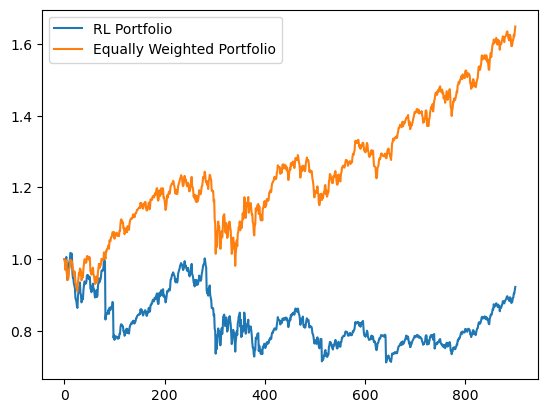

In [26]:
plt.plot(np.array(port_val), label='RL Portfolio')
plt.plot(np.array(eq_pf_val), label='Equally Weighted Portfolio')
# plt.yscale('log')
plt.legend()
plt.show()

In [4]:
class TwoHundredNewsRandomizedTest(PortfolioEnvWithTCostNews): 
    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('200_random_sample_tickers.csv')
        self.tickers = df.TICKER.unique()
        
        # create stock array
        pivot_price_df = df.pivot(index='date', columns='TICKER', values='PRC')
        stock_array = pivot_price_df.values.astype(float)
        
        # adjust for stock splits
        pivot_facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR')
        facpr_array = pivot_facpr_df.values.astype(float)
        self.stock_array = stock_array * (1+facpr_array).cumprod(axis=0)
        self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
        
        # print(normal_ret)
    
        normal_ret = pivot_price_df.pct_change().iloc[1:, :]

        self.times = df.date.unique()[100:]

        exp_ret = np.exp(self.ret)
        self.idx_df = pd.DataFrame(exp_ret, index = df.date.unique()[1:])
    
        
        # read index data and compute volatilities
        daily_return = normal_ret.mean(axis = 1)
        
        
        vol_20 = daily_return.rolling(20).std()
        vol_60 = daily_return.rolling(60).std()
        self.vol_20 = vol_20[self.times].values
        self.vol_60 = vol_60[self.times].values
        
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix = vix_df.loc[self.times].vix.values
        
        
        self.num_time_periods = len(self.times)-100-1
        self.universe_size = len(self.tickers)

        #get news sentiment data
        means_df = pd.read_csv('./news_sentiment_data_5.csv')
        means_df['Date'] = pd.to_datetime(means_df['Date'], errors='coerce')

        #filter date range
        means_df = means_df[(means_df.Date.dt.year >= 2010) & (means_df.Date.dt.year < 2015)]
        means_df = means_df.loc[means_df['Ticker'].isin(self.tickers)]

        #pivot to create an array that's easier to work with
        news_sentiment_array = means_df.pivot(index="Date", columns="Ticker", values="sentiment_embedding")
        
        #reindex the dataframe so that missing times are filled properly
        news_sentiment_array = news_sentiment_array.reindex(self.times).fillna(0)
        no_sentiment_tickers = list(set(self.tickers) - set(news_sentiment_array.columns.values))

        news_sentiment_array[[no_sentiment_tickers]] = 0
        self.news_sentiment_array = news_sentiment_array
       

        return len(self.times)-100 - 1, len(self.tickers)

In [5]:
vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
    'dm': TwoHundredNewsRandomizedTest(),
    'rm': DifferentialSharpeRatioReward(),
    'cp': 0,
    'cs': 0
})

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(43)
torch.manual_seed(42)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=100_000)
model.save("tcost_portfolio_rl_model_framework_200_news")

/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/352771184.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/352771184.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/352771184.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/352771184.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/3527711

Using cpu device


/Users/ravipanguluri/miniconda3/envs/portfolio-rl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.06e+03 |
|    ep_rew_mean     | -44      |
| time/              |          |
|    fps             | 2992     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 8192     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.06e+03   |
|    ep_rew_mean          | -43.5      |
| time/                   |            |
|    fps                  | 955        |
|    iterations           | 2          |
|    time_elapsed         | 17         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.12237505 |
|    clip_fraction        | 0.533      |
|    clip_range           | 0.2        |
|    entropy_loss         | -285       |
|    explained_variance   | -0.000839  |
|    learning_rate        | 0.0003     |
|   

In [7]:
env = PortfolioEnvWithTCost(dm=TwoHundredNewsRandomizedTest(), rm=DifferentialSharpeRatioReward(), cp=0, cs=0)
obs, _ = env.reset()

port_val = [1.0]
eq_pf_val = [1.0]
actions = []
ys = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    port_val.append(info['port_val'])
    eq_pf_val.append(eq_pf_val[-1] * (env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t]].mean(axis = 1).values[0]))
    if terminated:
        break

/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/352771184.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/352771184.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))


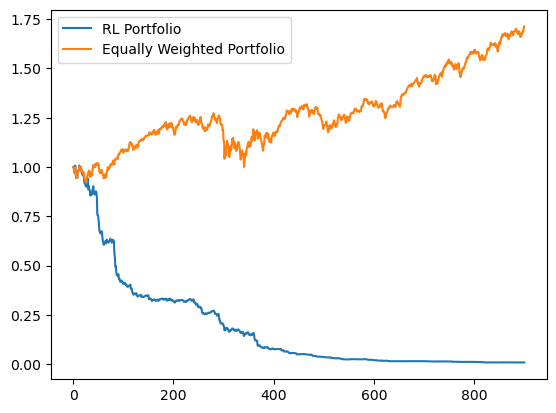

In [8]:
plt.plot(np.array(port_val), label='RL Portfolio')
plt.plot(np.array(eq_pf_val), label='Equally Weighted Portfolio')
# plt.yscale('log')
plt.legend()
plt.show()

In [9]:
class FiveHundredNewsRandomizedTest(PortfolioEnvWithTCostNews): 
    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('500_random_sample_tickers.csv')
        self.tickers = df.TICKER.unique()
        
        # create stock array
        pivot_price_df = df.pivot(index='date', columns='TICKER', values='PRC')
        stock_array = pivot_price_df.values.astype(float)
        
        # adjust for stock splits
        pivot_facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR')
        facpr_array = pivot_facpr_df.values.astype(float)
        self.stock_array = stock_array * (1+facpr_array).cumprod(axis=0)
        self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
        
        # print(normal_ret)
    
        normal_ret = pivot_price_df.pct_change().iloc[1:, :]

        self.times = df.date.unique()[100:]

        exp_ret = np.exp(self.ret)
        self.idx_df = pd.DataFrame(exp_ret, index = df.date.unique()[1:])
    
        
        # read index data and compute volatilities
        daily_return = normal_ret.mean(axis = 1)
        
        
        vol_20 = daily_return.rolling(20).std()
        vol_60 = daily_return.rolling(60).std()
        self.vol_20 = vol_20[self.times].values
        self.vol_60 = vol_60[self.times].values
        
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix = vix_df.loc[self.times].vix.values
        
        
        self.num_time_periods = len(self.times)-100-1
        self.universe_size = len(self.tickers)

        #get news sentiment data
        means_df = pd.read_csv('./news_sentiment_data_5.csv')
        means_df['Date'] = pd.to_datetime(means_df['Date'], errors='coerce')

        #filter date range
        means_df = means_df[(means_df.Date.dt.year >= 2010) & (means_df.Date.dt.year < 2015)]
        means_df = means_df.loc[means_df['Ticker'].isin(self.tickers)]

        #pivot to create an array that's easier to work with
        news_sentiment_array = means_df.pivot(index="Date", columns="Ticker", values="sentiment_embedding")
        
        #reindex the dataframe so that missing times are filled properly
        news_sentiment_array = news_sentiment_array.reindex(self.times).fillna(0)
        no_sentiment_tickers = list(set(self.tickers) - set(news_sentiment_array.columns.values))

        news_sentiment_array[[no_sentiment_tickers]] = 0
        self.news_sentiment_array = news_sentiment_array
       

        return len(self.times)-100 - 1, len(self.tickers)


In [10]:

vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
    'dm': FiveHundredNewsRandomizedTest(),
    'rm': DifferentialSharpeRatioReward(),
    'cp': 0,
    'cs': 0
})

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(43)
torch.manual_seed(42)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=100_000)
model.save("tcost_portfolio_rl_model_framework_500_news")


/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/4028311515.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/4028311515.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/4028311515.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/4028311515.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/402

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.06e+03 |
|    ep_rew_mean     | -52.8    |
| time/              |          |
|    fps             | 1417     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1.06e+03  |
|    ep_rew_mean          | -52.5     |
| time/                   |           |
|    fps                  | 513       |
|    iterations           | 2         |
|    time_elapsed         | 31        |
|    total_timesteps      | 16384     |
| train/                  |           |
|    approx_kl            | 155.14703 |
|    clip_fraction        | 0.739     |
|    clip_range           | 0.2       |
|    entropy_loss         | -711      |
|    explained_variance   | -0.0084   |
|    learning_rate        | 0.0003    |
|  

In [11]:

env = PortfolioEnvWithTCost(dm=FiveHundredNewsRandomizedTest(), rm=DifferentialSharpeRatioReward(), cp=0, cs=0)
obs, _ = env.reset()

port_val = [1.0]
eq_pf_val = [1.0]
actions = []
ys = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    port_val.append(info['port_val'])
    eq_pf_val.append(eq_pf_val[-1] * (env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t]].mean(axis = 1).values[0]))
    if terminated:
        break


/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/4028311515.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/4028311515.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))


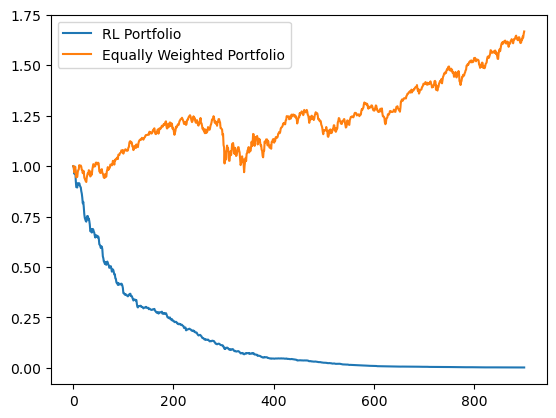

In [12]:

plt.plot(np.array(port_val), label='RL Portfolio')
plt.plot(np.array(eq_pf_val), label='Equally Weighted Portfolio')
# plt.yscale('log')
plt.legend()
plt.show()

In [13]:
class ThousandNewsRandomizedTest(PortfolioEnvWithTCostNews): 
    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('1000_random_sample_tickers.csv')
        self.tickers = df.TICKER.unique()
        
        # create stock array
        pivot_price_df = df.pivot(index='date', columns='TICKER', values='PRC')
        stock_array = pivot_price_df.values.astype(float)
        
        # adjust for stock splits
        pivot_facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR')
        facpr_array = pivot_facpr_df.values.astype(float)
        self.stock_array = stock_array * (1+facpr_array).cumprod(axis=0)
        self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
        
        # print(normal_ret)
    
        normal_ret = pivot_price_df.pct_change().iloc[1:, :]

        self.times = df.date.unique()[100:]

        exp_ret = np.exp(self.ret)
        self.idx_df = pd.DataFrame(exp_ret, index = df.date.unique()[1:])
    
        
        # read index data and compute volatilities
        daily_return = normal_ret.mean(axis = 1)
        
        
        vol_20 = daily_return.rolling(20).std()
        vol_60 = daily_return.rolling(60).std()
        self.vol_20 = vol_20[self.times].values
        self.vol_60 = vol_60[self.times].values
        
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix = vix_df.loc[self.times].vix.values
        
        
        self.num_time_periods = len(self.times)-100-1
        self.universe_size = len(self.tickers)

        #get news sentiment data
        means_df = pd.read_csv('./news_sentiment_data_5.csv')
        means_df['Date'] = pd.to_datetime(means_df['Date'], errors='coerce')

        #filter date range
        means_df = means_df[(means_df.Date.dt.year >= 2010) & (means_df.Date.dt.year < 2015)]
        means_df = means_df.loc[means_df['Ticker'].isin(self.tickers)]

        #pivot to create an array that's easier to work with
        news_sentiment_array = means_df.pivot(index="Date", columns="Ticker", values="sentiment_embedding")
        
        #reindex the dataframe so that missing times are filled properly
        news_sentiment_array = news_sentiment_array.reindex(self.times).fillna(0)
        no_sentiment_tickers = list(set(self.tickers) - set(news_sentiment_array.columns.values))

        news_sentiment_array[[no_sentiment_tickers]] = 0
        self.news_sentiment_array = news_sentiment_array
       

        return len(self.times)-100 - 1, len(self.tickers)
    

In [14]:
vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
    'dm': ThousandNewsRandomizedTest(),
    'rm': DifferentialSharpeRatioReward(),
    'cp': 0,
    'cs': 0
})

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(43)
torch.manual_seed(42)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=100_000)
model.save("tcost_portfolio_rl_model_framework_1000_news")


/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/1567889405.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/1567889405.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/1567889405.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/1567889405.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/156

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.06e+03 |
|    ep_rew_mean     | -78.1    |
| time/              |          |
|    fps             | 682      |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 8192     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1.06e+03  |
|    ep_rew_mean          | -79.3     |
| time/                   |           |
|    fps                  | 257       |
|    iterations           | 2         |
|    time_elapsed         | 63        |
|    total_timesteps      | 16384     |
| train/                  |           |
|    approx_kl            | 619288.25 |
|    clip_fraction        | 0.832     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.42e+03 |
|    explained_variance   | -0.00315  |
|    learning_rate        | 0.0003    |
|  

In [17]:

env = PortfolioEnvWithTCost(dm=ThousandNewsRandomizedTest(), rm=DifferentialSharpeRatioReward(), cp=0, cs=0)
obs, _ = env.reset()

port_val = [1.0]
eq_pf_val = [1.0]
actions = []
ys = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    port_val.append(info['port_val'])
    eq_pf_val.append(eq_pf_val[-1] * (env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t]].mean(axis = 1).values[0]))
    if terminated:
        break


/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/1567889405.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_45511/1567889405.py:15: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))


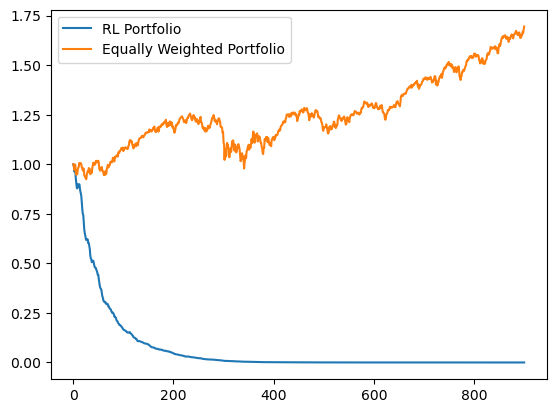

In [18]:

plt.plot(np.array(port_val), label='RL Portfolio')
plt.plot(np.array(eq_pf_val), label='Equally Weighted Portfolio')
# plt.yscale('log')
plt.legend()
plt.show()